<a href="https://colab.research.google.com/github/jiaminho/RPH-HAC-Prediction/blob/jiamin_branch/HAC_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hospital Acquired Complications (HACs)

**GitHub Repository**: https://github.com/jiaminho/RPH-HAC-Prediction/tree/main

 **MIMIC-III**
- https://mimic.mit.edu/docs/iii/
- https://physionet.org/content/mimiciii/1.4/
- https://mit-lcp.github.io/mimic-schema-spy/index.html (schema)

MIMIC-III is a relational database consisting of 26 tables. Tables are linked by identifiers which usually have the suffix ‘ID’. For example, SUBJECT_ID refers to a unique patient, HADM_ID refers to a unique admission to the hospital, and ICUSTAY_ID refers to a unique admission to an intensive care unit.

Five tables are used to define and track patient stays: ADMISSIONS; PATIENTS; ICUSTAYS; SERVICES; and TRANSFERS. Another five tables are dictionaries for cross-referencing codes against their respective definitions: D_CPT; D_ICD_DIAGNOSES; D_ICD_PROCEDURES; D_ITEMS; and D_LABITEMS. The remaining tables contain data associated with patient care, such as physiological measurements, caregiver observations, and billing information.

- mimic code repository: https://github.com/MIT-LCP/mimic-code
- mimic paper: https://www.nature.com/articles/sdata201635
- mimic website github: https://github.com/MIT-LCP/mimic-website
- mimic paper github: https://github.com/MIT-LCP/mimic-iii-paper/tree/master

HAC list: https://www.safetyandquality.gov.au/publications-and-resources/resource-library/hospital-acquired-complications-hacs-list-specifications-version-31-12th-edn

**Import necessary libraries**

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.models import Model, Sequential
# from sklearn.preprocessing import StandardScaler, OneHotEncoder

pd.set_option('display.max_columns', None)  # None ensures all columns are shown
warnings.simplefilter(action='ignore', category=FutureWarning)

Import Data from Google Drive to **Google Colab**

In [ ]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Function to download a file
def download_file(file_id, file_name):
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(file_name)

# List of files and their IDs
files_to_download = {
    'D_LABITEMS.csv': '1YsUqF-NkdLUL2hWRaxQgE7pyB1lGv4ox',
    'D_ICD_PROCEDURES.csv': '10nZG-naIdrVd1wj7JI5cwYDx4a8sp738',
    'D_ITEMS.csv': '11Jy050RqqIRPnsgbM6-YSRILyvIKRxJk',

    'D_ICD_DIAGNOSES.csv': '1d8oxIZy-UY1AflEgmYugfTFHKn9tiK_P',
    'PATIENTS.csv': '1JI_F9GBr7ul5c-c4C1x0xxcfOB3BOTxv',
    'PROCEDURES_ICD.csv': '1eWYJMBcujAlKohuDyl99obl9wZzaveu4',
    'ADMISSIONS.csv': '1zfjctJQU-FtY-EOoUh_f4_bSVrPOn0Kc',
    'DIAGNOSES_ICD.csv': '1O_5wyg0LHDnlKq8ULLyVG0hC862fqoJb',
    'MICROBIOLOGYEVENTS.csv': '1IpH9qE80J50CQmn6jmw_IfpcirsT94ax',
    'LABEVENTS.csv': '1zAIm6nbkWrAtHNu06J34ygsPavYtpCjR'
}

# Download all files
for file_name, file_id in files_to_download.items():
    download_file(file_id, file_name)

**Read files**

In [ ]:
d_labitems = pd.read_csv('D_LABITEMS.csv')       # 44K
d_icd_procedures = pd.read_csv('D_ICD_PROCEDURES.csv') #300K
d_items = pd.read_csv('D_ITEMS.csv')           # 936K
d_icd_diagnoses = pd.read_csv('D_ICD_DIAGNOSES.csv') # 1.4M
patients = pd.read_csv('PATIENTS.csv')         # 2.6M
procedures_icd = pd.read_csv('PROCEDURES_ICD.csv')  # 6.5M
admissions = pd.read_csv('ADMISSIONS.csv')      # 12M
diagnoses_icd = pd.read_csv('DIAGNOSES_ICD.csv')   # 19M
microbiologyevents = pd.read_csv('MICROBIOLOGYEVENTS.csv')  # 70M
labevents = pd.read_csv('LABEVENTS.csv')       # 1.8G

# d_cpt = pd.read_csv('D_CPT.csv')               # 16K
# caregivers = pd.read_csv('CAREGIVERS.csv')     # 200K
# services = pd.read_csv('SERVICES.csv')         # 3.4M
# callout = pd.read_csv('CALLOUT.csv')           # 6.1M
# icustays = pd.read_csv('ICUSTAYS.csv')         # 6.1M
# drgcodes = pd.read_csv('DRGCODES.csv')         # 11M
# transfers = pd.read_csv('TRANSFERS.csv')       # 24M
# procedureevents_mv = pd.read_csv('PROCEDUREEVENTS_MV.csv') # 47M
# cptevents = pd.read_csv('CPTEVENTS.csv') # 56M
# outputevents = pd.read_csv('OUTPUTEVENTS.csv')  # 379M
# datetimeevents = pd.read_csv('DATETIMEEVENTS.csv') # 502M
# prescriptions = pd.read_csv('PRESCRIPTIONS.csv') # 735M
# inputevents_mv = pd.read_csv('INPUTEVENTS_MV.csv') # 931M
# inputevents_cv = pd.read_csv('INPUTEVENTS_CV.csv') # 2.3G
# noteevents = pd.read_csv('NOTEEVENTS.csv')     # 3.5G

<div class="alert alert-block alert-info">
<h2>Exploratory Data Analysis and Data Cleaning</h2>
</div>


### 1. ADMISSIONS.csv

In [ ]:
admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [ ]:
admissions.shape

(58976, 19)

There are 58976 admissions with 19 variables

In [ ]:
missing_values = admissions.isnull().sum()
missing_values

ROW_ID                      0
SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               53122
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                25332
RELIGION                  458
MARITAL_STATUS          10128
ETHNICITY                   0
EDREGTIME               28099
EDOUTTIME               28099
DIAGNOSIS                  25
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
dtype: int64

53 122 values (~ 90.1%) are missing for Deathtime. These missing values likely represent those that survived and hence did not have a time of death. EDREGTIME and EDOUTTIME are both missing 28 099 values (~ 47.6%). 25 332 values (~ 43.0%) are missing for Language. 10 128 values (17.2%) are missing from Marital Status. 458 values (~ 0.8%) are missing for religion. Diagnosis is missing 25 values (~ 0.04%).

In [ ]:
print("Number of Unique Values for Each Column")
for i in admissions.columns.tolist():
    unique_values = len(admissions[i].unique())
    print(f"{i}: {unique_values}")

Number of Unique Values for Each Column
ROW_ID: 58976
SUBJECT_ID: 46520
HADM_ID: 58976
ADMITTIME: 58651
DISCHTIME: 58657
DEATHTIME: 5835
ADMISSION_TYPE: 4
ADMISSION_LOCATION: 9
DISCHARGE_LOCATION: 17
INSURANCE: 5
LANGUAGE: 76
RELIGION: 21
MARITAL_STATUS: 8
ETHNICITY: 41
EDREGTIME: 30875
EDOUTTIME: 30865
DIAGNOSIS: 15692
HOSPITAL_EXPIRE_FLAG: 2
HAS_CHARTEVENTS_DATA: 2


There are 15692 unique values in the 'DIAGNOSIS' column.

Top 20 Most Common Admission Diagnoses

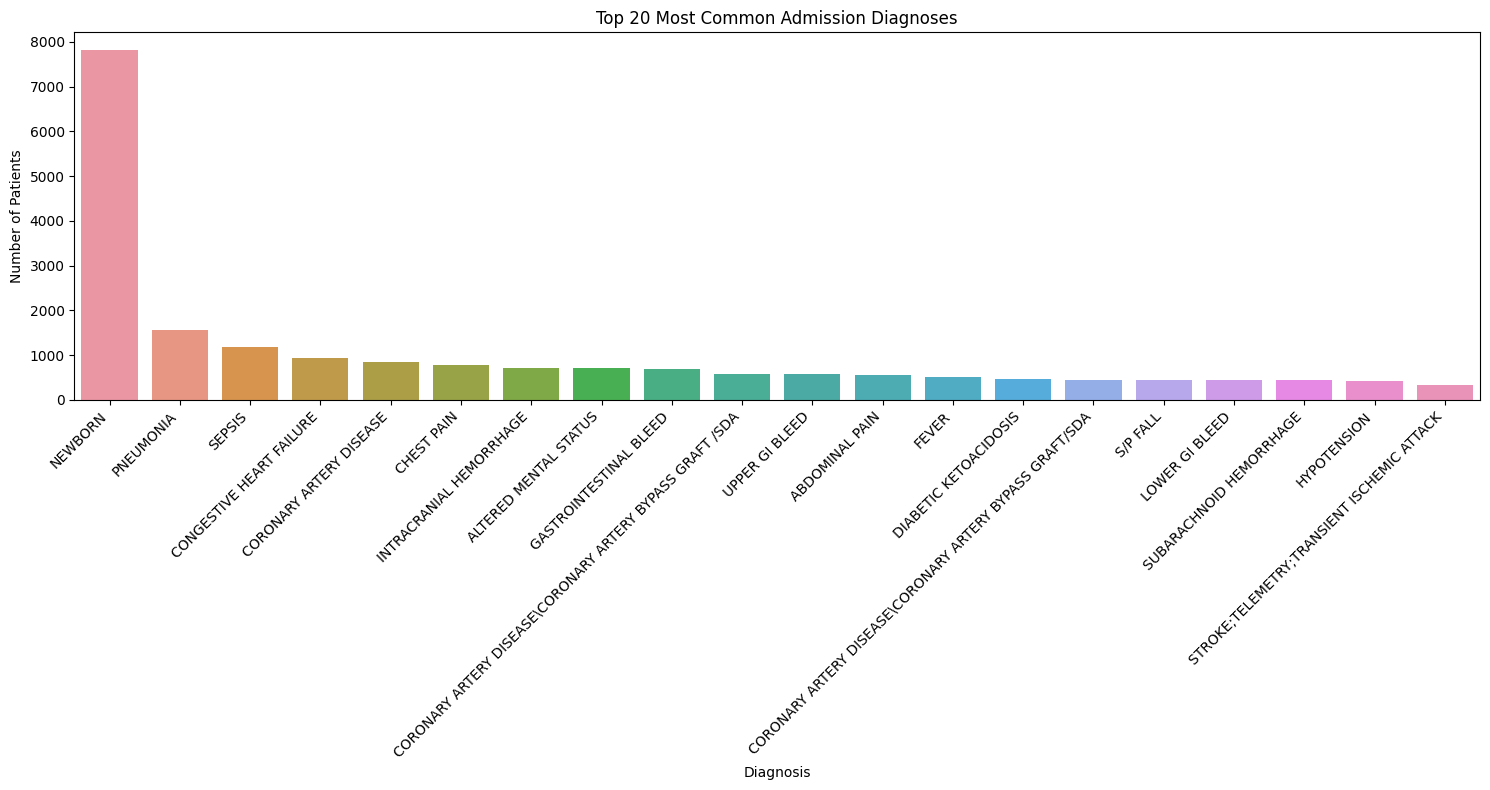

In [ ]:
# Count the occurrences of each diagnosis
diagnosis_counts = admissions['DIAGNOSIS'].value_counts()

# Take the top 20 most common diagnoses
top_diagnoses = diagnosis_counts.head(20)

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(x=top_diagnoses.index, y=top_diagnoses.values)
plt.title('Top 20 Most Common Admission Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')  # Rotate the diagnosis names for better readability
plt.tight_layout()
plt.show()

Bar plot above shows the most common admission diagnoses.

In [ ]:
# function for plotting horizontal bar plots
def plot_categorical_data(column_name, df):
    plt.figure(figsize=(15, 8))
    sns.countplot(data=df, y=column_name, order = df[column_name].value_counts().index)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel('Number of Admissions')
    plt.tight_layout()
    plt.show()

# function for plotting verical bar plots
def plot_vertical_categorical_data(column_name, df, top_n, fontsize=8):
    df_counts = df[column_name].value_counts()
    top_X = df_counts.head(top_n)

    plt.figure(figsize=(5, 4))
    sns.barplot(x=top_X.index, y=top_X.values)

    plt.title('Top '+str(top_n)+' Most Common ' + column_name, fontsize=fontsize+2)
    plt.xlabel(column_name, fontsize=fontsize)
    plt.ylabel('Number of Admissions', fontsize=fontsize)
    plt.xticks(rotation=45, ha='right', fontsize=fontsize)  # Rotate the diagnosis names for better readability
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()
    plt.show()

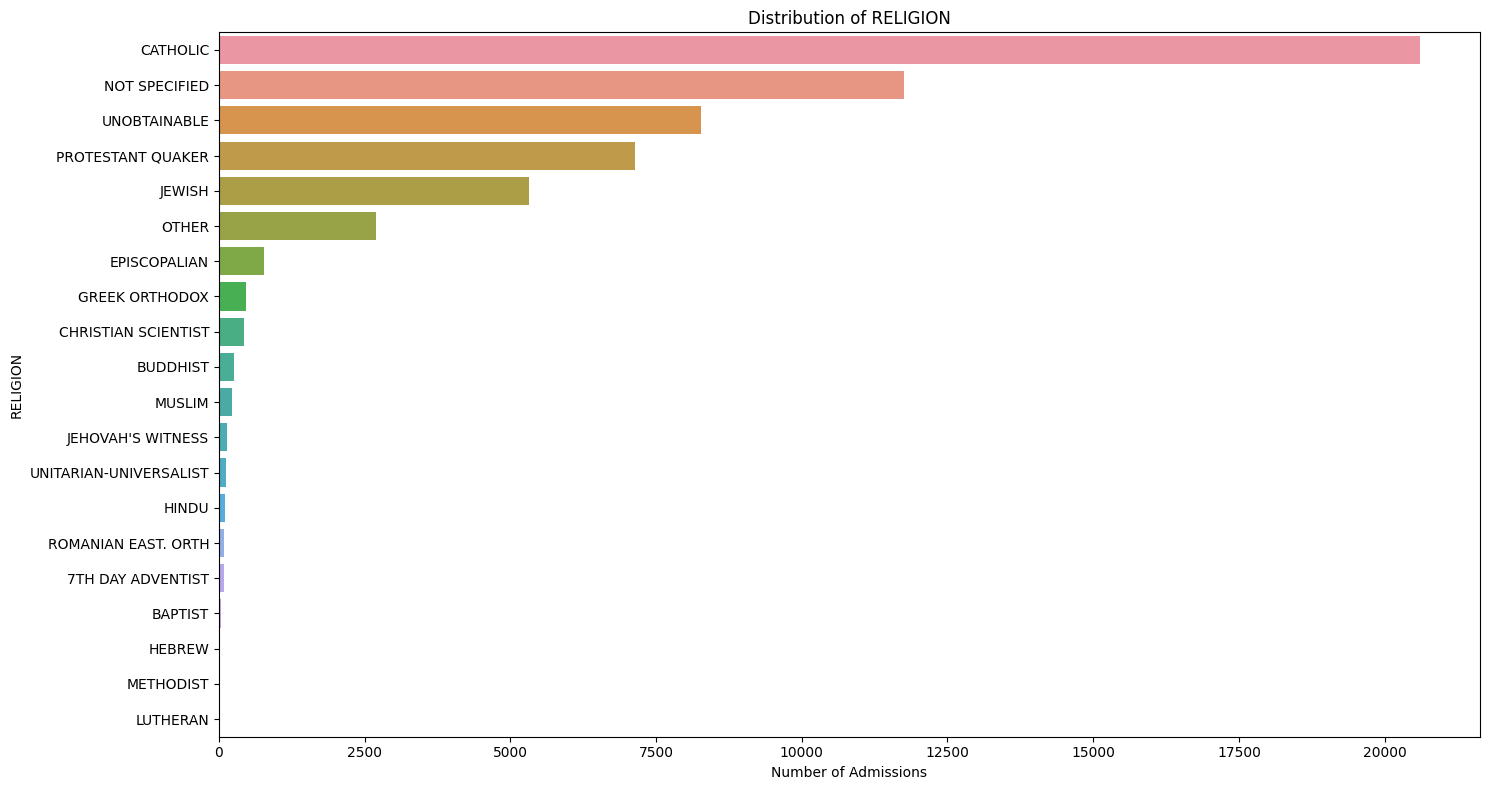

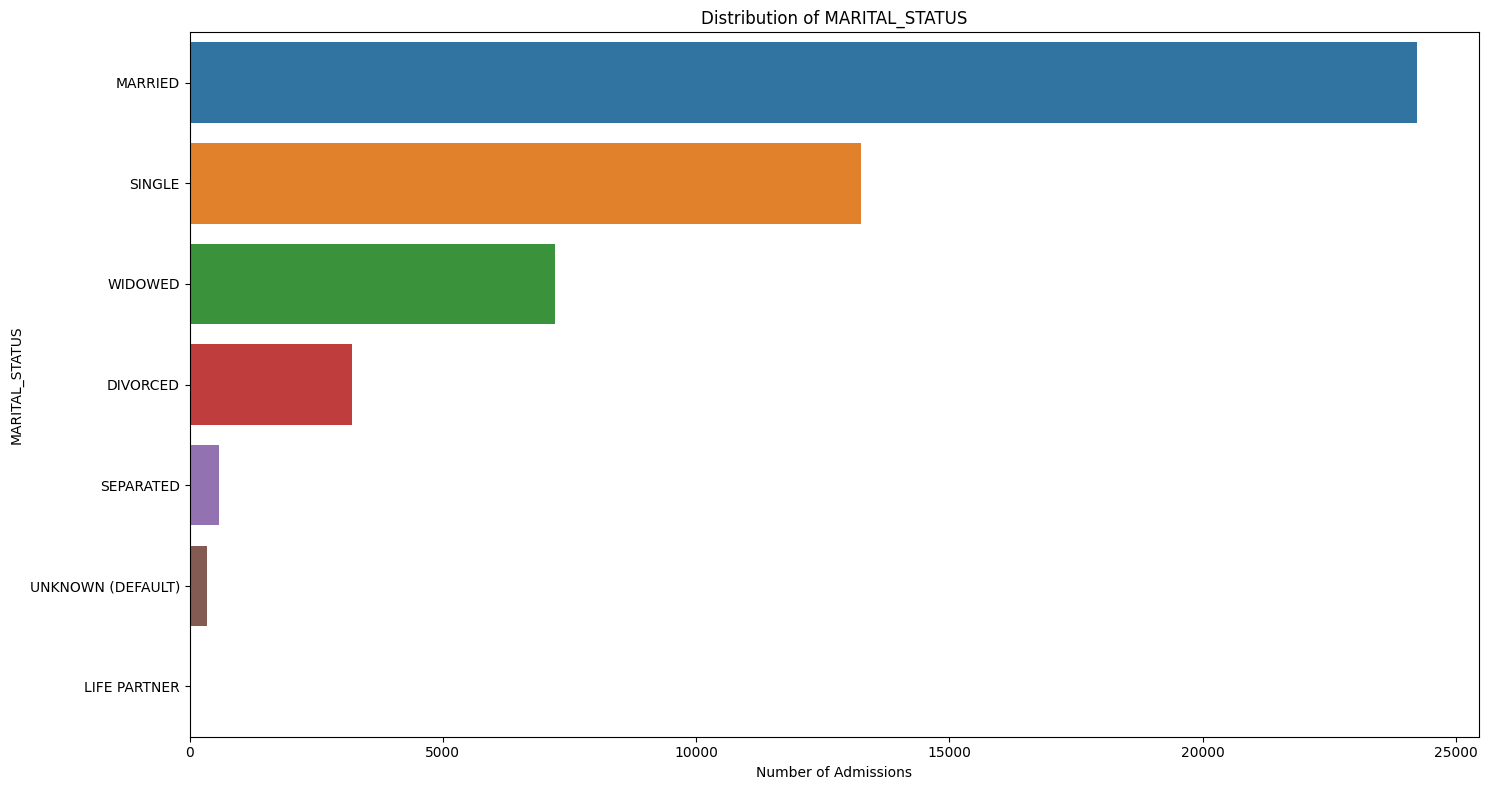

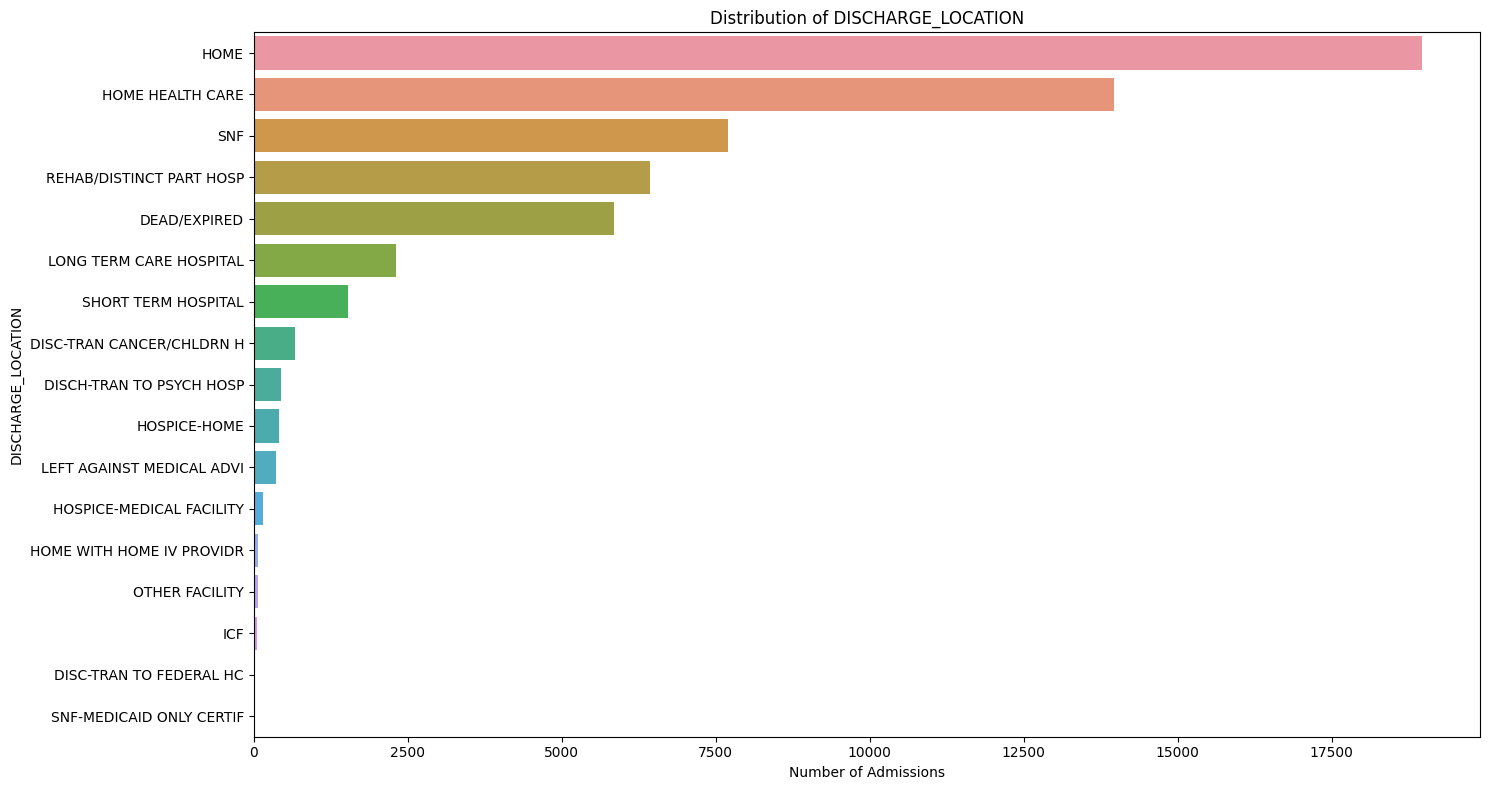

In [ ]:
# Visualizing each column
for column in ['RELIGION', 'MARITAL_STATUS', 'DISCHARGE_LOCATION',]:
    plot_categorical_data(column, admissions)

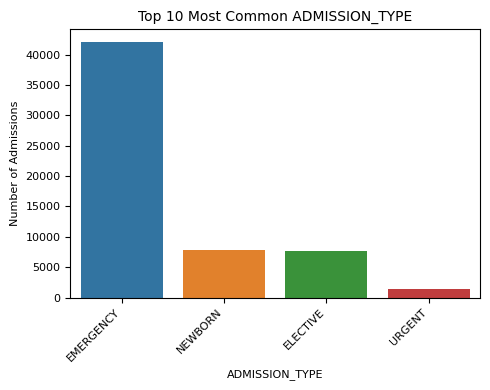

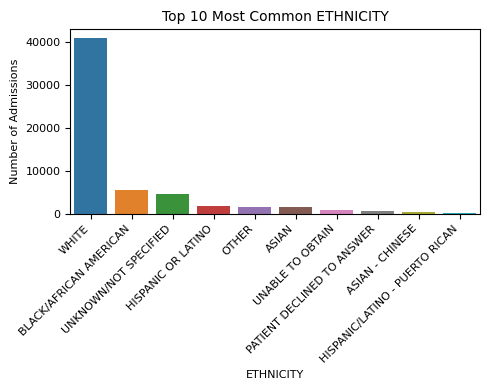

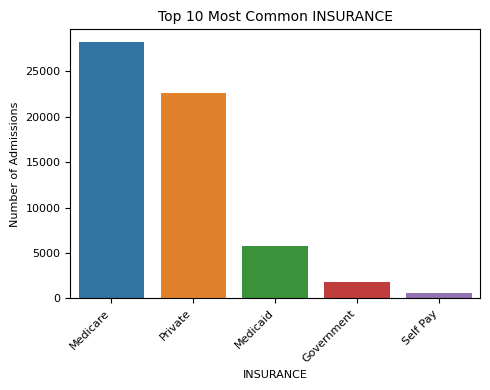

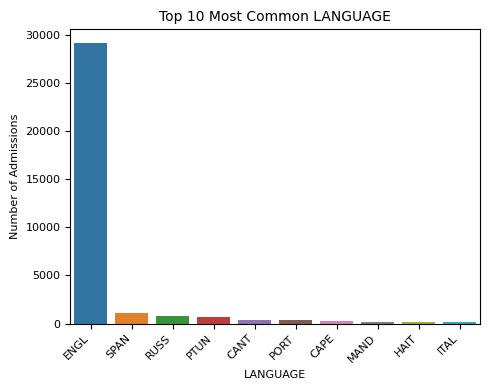

In [ ]:
for column in ['ADMISSION_TYPE', 'ETHNICITY', 'INSURANCE', 'LANGUAGE', ]:
    plot_vertical_categorical_data(column, df=admissions, top_n=10)

Visualize percentage of patients died

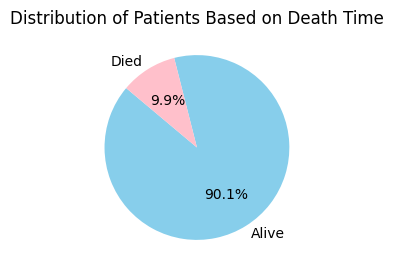

In [ ]:
# Create a new column 'DEATH_STATUS' to classify patients
admissions['DEATH_STATUS'] = admissions['DEATHTIME'].apply(lambda x: 'Died' if pd.notna(x) else 'Alive')

# Get the counts of each category
death_counts = admissions['DEATH_STATUS'].value_counts()

# Plot
plt.figure(figsize=(5,3))
plt.pie(death_counts, labels=death_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'pink'])
plt.title('Distribution of Patients Based on Death Time')
plt.show()

**Add admission_duration column**

In [ ]:
# calculate admission duration
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])

admissions['admission_duration'] = admissions['DISCHTIME'] - admissions['ADMITTIME']

print(admissions['admission_duration'])

0        1 days 03:28:00
1        5 days 11:55:00
2        6 days 18:26:00
3        2 days 20:34:00
4        3 days 12:49:00
              ...       
58971    2 days 17:49:00
58972    0 days 13:10:00
58973    8 days 04:53:00
58974   41 days 10:42:00
58975    1 days 14:35:00
Name: admission_duration, Length: 58976, dtype: timedelta64[ns]


### 2. PATIENTS.csv

In [ ]:
patients

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
46515,31840,44089,M,2026-05-25 00:00:00,NaN,NaN,NaN,0
46516,31841,44115,F,2124-07-27 00:00:00,NaN,NaN,NaN,0
46517,31842,44123,F,2049-11-26 00:00:00,2135-01-12 00:00:00,2135-01-12 00:00:00,NaN,1
46518,31843,44126,F,2076-07-25 00:00:00,NaN,NaN,NaN,0


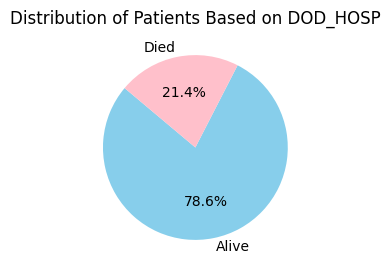

In [ ]:
# Create a new column 'DEATH_HOSP' to classify patients died in hospital
patients['DEATH_HOSP'] = patients['DOD_HOSP'].apply(lambda x: 'Died' if pd.notna(x) else 'Alive')

# Get the counts of each category
death_counts = patients['DEATH_HOSP'].value_counts()

# Plot
plt.figure(figsize=(5,3))
plt.pie(death_counts, labels=death_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'pink'])
plt.title('Distribution of Patients Based on DOD_HOSP')
plt.show()

show distribution of gender

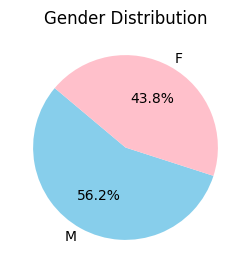

In [ ]:
# Count occurrences of each gender
gender_counts = patients['GENDER'].value_counts()

# Plot pie chart
plt.figure(figsize=(5, 3))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'pink'])
plt.title('Gender Distribution')
plt.show()

### admission_merged

Merge patient data with admission data

In [ ]:
# Merge patients with admission using a left merge
admission_merged = pd.merge(admissions, patients, on='SUBJECT_ID', how='left')
admission_merged

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,DEATH_STATUS,admission_duration,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,DEATH_HOSP
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,Alive,1 days 03:28:00,19,F,2131-05-07 00:00:00,NaN,NaN,NaN,0,Alive
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,Alive,5 days 11:55:00,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0,Alive
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,Alive,6 days 18:26:00,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0,Alive
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,Alive,2 days 20:34:00,21,M,2100-05-31 00:00:00,NaN,NaN,NaN,0,Alive
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,Alive,3 days 12:49:00,22,M,2101-11-21 00:00:00,NaN,NaN,NaN,0,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,2131-03-30 19:44:00,2131-03-30 22:41:00,TRAUMA,0,1,Alive,2 days 17:49:00,46213,F,2111-11-05 00:00:00,NaN,NaN,NaN,0,Alive
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2151-03-05 17:23:00,2151-03-05 21:06:00,SAH,1,1,Died,0 days 13:10:00,46214,F,2067-09-21 00:00:00,2151-03-06 00:00:00,2151-03-06 00:00:00,NaN,1,Died
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,RENAL CANCER/SDA,0,1,Alive,8 days 04:53:00,46215,M,2158-03-02 00:00:00,NaN,NaN,NaN,0,Alive
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,CATHOLIC,MARRIED,WHITE,2128-11-10 23:48:00,2128-11-11 03:16:00,S/P FALL,0,0,Alive,41 days 10:42:00,46216,F,2068-02-04 00:00:00,NaN,NaN,NaN,0,Alive


In [ ]:
duplicated_count = admission_merged.duplicated().sum()
print(f"Number of duplicated rows: {duplicated_count}")

Number of duplicated rows: 0


**Calculate the age** of each patient using the 'DOB' column. However, it's essential to be aware that dates in MIMIC-III have been shifted to protect patient privacy. Therefore, we're calculating a pseudonymized age rather than the actual age.

In [ ]:
# Convert ADMITTIME and DOB to datetime format
admission_merged['ADMITTIME'] = pd.to_datetime(admission_merged['ADMITTIME'])
admission_merged['DOB'] = pd.to_datetime(admission_merged['DOB'])


def calculate_age(admit_time, dob):
    try:
        # Convert pandas timestamps to Python datetime objects
        admit_datetime = admit_time.to_pydatetime()
        dob_datetime = dob.to_pydatetime()

        # Calculate age
        age = int((admit_datetime - dob_datetime).days // 365.25)
        return age if age > 0 else np.nan  # Assign NaN for negative ages
    except OverflowError:
        return np.nan

# Use the 'apply' method with the function
admission_merged['AGE_AT_ADMISSION'] = admission_merged.apply(lambda row: calculate_age(row['ADMITTIME'], row['DOB']), axis=1)
admission_merged.head()

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,DEATH_STATUS,admission_duration,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,DEATH_HOSP,AGE_AT_ADMISSION
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,Alive,1 days 03:28:00,19,F,2131-05-07,NaN,NaN,NaN,0,Alive,64.0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,Alive,5 days 11:55:00,20,M,2082-07-17,NaN,NaN,NaN,0,Alive,71.0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,Alive,6 days 18:26:00,20,M,2082-07-17,NaN,NaN,NaN,0,Alive,75.0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,Alive,2 days 20:34:00,21,M,2100-05-31,NaN,NaN,NaN,0,Alive,39.0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,Alive,3 days 12:49:00,22,M,2101-11-21,NaN,NaN,NaN,0,Alive,58.0


In [ ]:
nan_count = admission_merged['DOB'].isna().sum()
print(f"The number of NaN values in the 'DOB' column is: {nan_count}")

The number of NaN values in the 'DOB' column is: 0


In [ ]:
nan_count = admission_merged['ADMITTIME'].isna().sum()
print(f"The number of NaN values in the 'ADMITTIME' column is: {nan_count}")

The number of NaN values in the 'ADMITTIME' column is: 0


In [ ]:
nan_count = admission_merged['AGE_AT_ADMISSION'].isna().sum()
print(f"The number of NaN values in the 'AGE_AT_ADMISSION' column is: {nan_count}")

The number of NaN values in the 'AGE_AT_ADMISSION' column is: 8110


In [ ]:
print(round(nan_count/58976*100), '% admissions have negative ages or encountered OverflowError when calculating age')

14 % admissions have negative ages or encountered OverflowError when calculating age


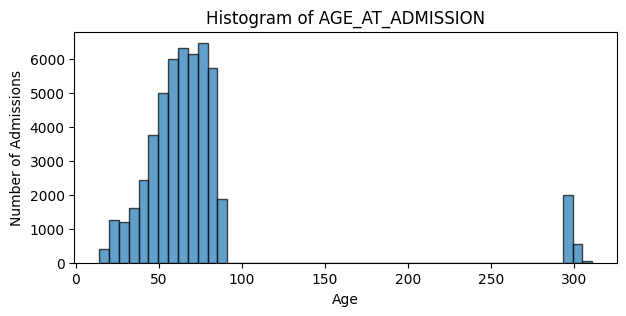

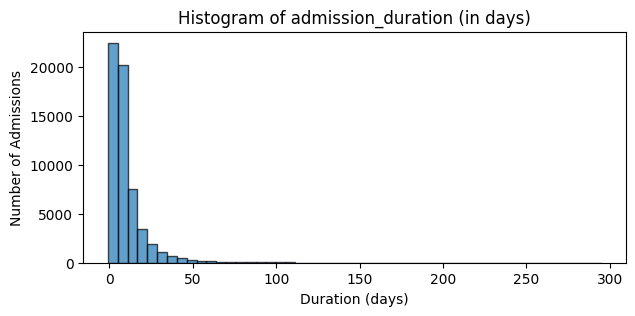

In [ ]:
# Plotting histogram for 'AGE_AT_ADMISSION'
plt.figure(figsize=(7, 3))
plt.hist(admission_merged['AGE_AT_ADMISSION'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram of AGE_AT_ADMISSION')
plt.xlabel('Age')
plt.ylabel('Number of Admissions')
plt.show()

# Plotting histogram for 'admission_duration'
# Convert the 'admission_duration' column to days
admission_duration_days = admission_merged['admission_duration'].dt.total_seconds() / (24 * 3600)

plt.figure(figsize=(7, 3))
plt.hist(admission_duration_days, bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram of admission_duration (in days)')
plt.xlabel('Duration (days)')
plt.ylabel('Number of Admissions')
plt.show()


There are some outliers in 'AGE_AT_ADMISSION', with some patients being ~300 years old.

In [ ]:
age_stats = admission_merged['AGE_AT_ADMISSION'].describe()
print("Statistics for AGE_AT_ADMISSION:")
print(age_stats)

Statistics for AGE_AT_ADMISSION:
count    50866.000000
mean        74.182008
std         54.934994
min         14.000000
25%         52.000000
50%         65.000000
75%         77.000000
max        311.000000
Name: AGE_AT_ADMISSION, dtype: float64


median age = 65

max age = 311?

In [ ]:
implausible_ages = admission_merged[admission_merged['AGE_AT_ADMISSION'] > 130]
implausible_ages

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,DEATH_STATUS,admission_duration,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,DEATH_HOSP,AGE_AT_ADMISSION
8,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1,Alive,5 days 00:20:00,26,M,1872-10-14,NaN,NaN,NaN,0,Alive,299.0
12,33,34,115799,2186-07-18 16:46:00,2186-07-20 16:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,CHEST PAIN\CATH,0,1,Alive,1 days 23:14:00,30,M,1886-07-18,2192-01-30 00:00:00,NaN,2192-01-30 00:00:00,1,Alive,299.0
13,34,34,144319,2191-02-23 05:23:00,2191-02-25 20:20:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2191-02-23 04:23:00,2191-02-23 07:25:00,BRADYCARDIA,0,1,Alive,2 days 14:57:00,30,M,1886-07-18,2192-01-30 00:00:00,NaN,2192-01-30 00:00:00,1,Alive,304.0
39,473,368,105889,2137-07-11 17:56:00,2137-07-16 16:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,NOT SPECIFIED,WIDOWED,WHITE,2137-07-11 15:00:00,2137-07-11 19:50:00,PNEUMONIA,0,1,Alive,4 days 22:04:00,347,M,1837-07-11,2141-01-28 00:00:00,NaN,2141-01-28 00:00:00,1,Alive,299.0
40,474,368,138061,2139-12-16 19:48:00,2139-12-22 16:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,NOT SPECIFIED,WIDOWED,WHITE,2139-12-15 21:10:00,2139-12-16 22:05:00,PNEUMONIA,0,1,Alive,5 days 20:27:00,347,M,1837-07-11,2141-01-28 00:00:00,NaN,2141-01-28 00:00:00,1,Alive,302.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58911,57504,95420,137041,2141-07-27 09:30:00,2141-08-02 17:53:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,REHAB/DISTINCT PART HOSP,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,NaN,NaN,"AORTIC STENOSIS\RE-DO STERNOTOMY, AORTIC VALVE...",0,1,Alive,6 days 08:23:00,45320,M,1841-07-27,NaN,NaN,NaN,0,Alive,299.0
58920,58543,98647,167391,2156-02-28 17:21:00,2156-03-09 14:49:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,RUSS,JEWISH,SINGLE,WHITE,2156-02-28 11:28:00,2156-02-28 20:33:00,LEFT FEMUR FRACTURE,0,1,Alive,9 days 21:28:00,46172,M,1856-02-28,2156-04-12 00:00:00,NaN,2156-04-12 00:00:00,1,Alive,299.0
58939,58562,98713,105148,2140-04-04 13:11:00,2140-04-07 17:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,NaN,NaN,ST-SEGMENT ELEVATION MYOCARDIAL INFARCTION\CAR...,0,1,Alive,3 days 03:49:00,46190,F,1840-04-04,NaN,NaN,NaN,0,Alive,299.0
58940,58563,98714,171885,2104-11-12 12:31:00,2104-11-15 14:40:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,JEWISH,UNKNOWN (DEFAULT),WHITE,NaN,NaN,CORONARY ARTERY DISEASE\RIGHT CORONARY ARTERY ...,0,1,Alive,3 days 02:09:00,46191,M,1804-11-12,2105-01-23 00:00:00,2105-01-23 00:00:00,2105-01-23 00:00:00,1,Died,299.0


There are 2616 admissions with implausible ages of > 130.

In [ ]:
print('percentage of implausible ages:', round(2616/58976*100), '%')

percentage of implausible ages: 4 %


Replace implausible age values (>130) with the median age

In [ ]:
# Compute the median age
median_age = admission_merged['AGE_AT_ADMISSION'].median()

# Replace values greater than 100 with the median age
admission_merged.loc[admission_merged['AGE_AT_ADMISSION'] > 130, 'AGE_AT_ADMISSION'] = median_age

In [ ]:
updated_age_stats = admission_merged['AGE_AT_ADMISSION'].describe()
print("Updated Statistics for AGE_AT_ADMISSION:")
print(updated_age_stats)

Updated Statistics for AGE_AT_ADMISSION:
count    50866.000000
mean        62.113278
std         16.171175
min         14.000000
25%         52.000000
50%         65.000000
75%         75.000000
max         88.000000
Name: AGE_AT_ADMISSION, dtype: float64


In [ ]:
duration_stats = admission_duration_days.describe()
print("Statistics for admission_duration:")
print(duration_stats)

Statistics for admission_duration:
count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: admission_duration, dtype: float64


- The minimum value being negative doesn't make sense for a duration.
- The large standard deviation relative to the mean suggests a wide spread in the data.
- The max value seems very high, although it might be plausible depending on the context.

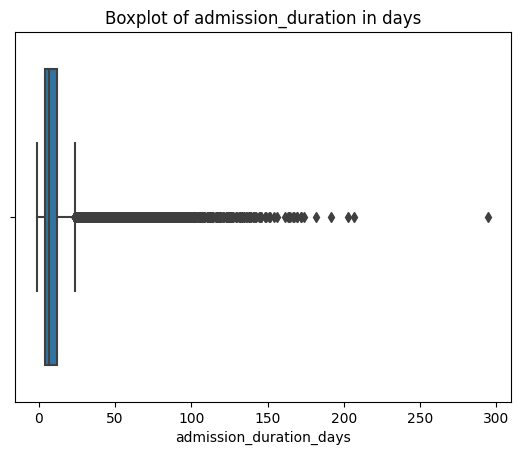

In [ ]:
# Convert timedelta to days
admission_merged['admission_duration_days'] = admission_merged['admission_duration'].dt.total_seconds() / (24 * 3600)

# Plot the boxplot
sns.boxplot(x=admission_merged['admission_duration_days'])
plt.title('Boxplot of admission_duration in days')
plt.show()

In [ ]:
count_over_200_days = (admission_merged['admission_duration_days'] > 200).sum()
print(count_over_200_days)

3


In [ ]:
count_negative_days = (admission_merged['admission_duration_days'] < 0).sum()
print(count_negative_days)

98


### 3. DIAGNOSES_ICD.csv

DIAGNOSES_ICD: recorded 6 weeks after patient discharged.

In [ ]:
diagnoses_icd

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254
...,...,...,...,...,...
651042,639798,97503,188195,2.0,20280
651043,639799,97503,188195,3.0,V5869
651044,639800,97503,188195,4.0,V1279
651045,639801,97503,188195,5.0,5275


In [ ]:
diagnoses_icd['ICD9_CODE'].isnull().sum()

47

47 admitted patients do not have ICD9_CODE

### 4. D_ICD_DIAGNOSES.csv

In [ ]:
d_icd_diagnoses

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."
...,...,...,...,...
14562,14432,V7399,Scrn unspcf viral dis,Special screening examination for unspecified ...
14563,14433,V740,Screening for cholera,Screening examination for cholera
14564,14434,V741,Screening-pulmonary TB,Screening examination for pulmonary tuberculosis
14565,14435,V742,Screening for leprosy,Screening examination for leprosy (Hansen's di...


### diagnosis_merged
Merge diagnosis ICD9_CODE to their respective names

In [ ]:
# Convert the ICD9_CODE columns in all DataFrames to string data type
d_icd_diagnoses['ICD9_CODE'] = d_icd_diagnoses['ICD9_CODE'].astype(str)
diagnoses_icd['ICD9_CODE'] = diagnoses_icd['ICD9_CODE'].astype(str)

# Merge diagnosis with diagnosis_icd using a left merge
diagnosis_merged = pd.merge(diagnoses_icd, d_icd_diagnoses, on='ICD9_CODE', how='left')
diagnosis_merged

,ROW_ID_x,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ROW_ID_y,SHORT_TITLE,LONG_TITLE
0,1297,109,172335,1.0,40301,4312.0,Mal hyp kid w cr kid V,"Hypertensive chronic kidney disease, malignant..."
1,1298,109,172335,2.0,486,5528.0,"Pneumonia, organism NOS","Pneumonia, organism unspecified"
2,1299,109,172335,3.0,58281,5892.0,Chr nephritis in oth dis,Chronic glomerulonephritis in diseases classif...
3,1300,109,172335,4.0,5855,5913.0,Chron kidney dis stage V,"Chronic kidney disease, Stage V"
4,1301,109,172335,5.0,4254,4435.0,Prim cardiomyopathy NEC,Other primary cardiomyopathies
...,...,...,...,...,...,...,...,...
651042,639798,97503,188195,2.0,20280,1859.0,Oth lymp unsp xtrndl org,"Other malignant lymphomas, unspecified site, e..."
651043,639799,97503,188195,3.0,V5869,12800.0,Long-term use meds NEC,Long-term (current) use of other medications
651044,639800,97503,188195,4.0,V1279,13957.0,Prsnl hst ot spf dgst ds,Personal history of other diseases of digestiv...
651045,639801,97503,188195,5.0,5275,5971.0,Sialolithiasis,Sialolithiasis


Since a patient can have multiple ICD-9 codes during a single admission (i.e., they can have multiple diagnoses), the SEQ_NUM helps in denoting the order or priority of those diagnoses. A SEQ_NUM of 1 denotes the primary diagnosis, which is often the main reason for the hospital admission.

In [ ]:
duplicated_count = diagnosis_merged.duplicated().sum()
print(f"Number of duplicated rows: {duplicated_count}")

Number of duplicated rows: 0


**Most Common ICD-9 Codes**

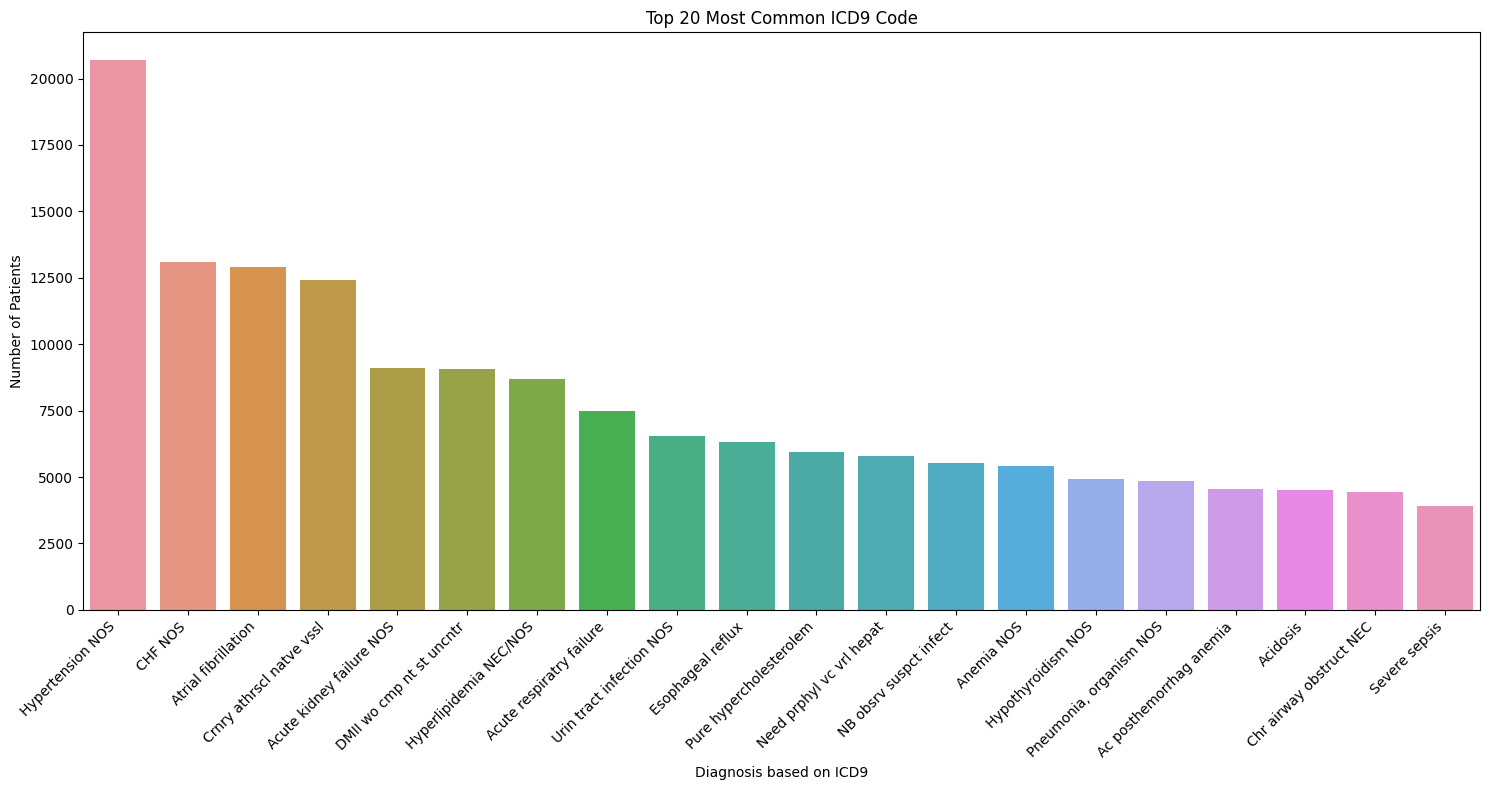

In [ ]:
# Count the occurrences of each icd
icd_counts = diagnosis_merged['SHORT_TITLE'].value_counts()

# Take the top 20 most common icd
top_icd = icd_counts.head(20)

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(x=top_icd.index, y=top_icd.values)
plt.title('Top 20 Most Common ICD9 Code')
plt.xlabel('Diagnosis based on ICD9')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')  # Rotate the diagnosis names for better readability
plt.tight_layout()
plt.show()

The bar chart above shows the top 20 most common ICD9 code.

Filter the diagnosis_merged table for the specific HADM_ID of 188195 and then retrieve the ICD9_CODE and SHORT_TITLE values associated with it

In [ ]:
# Filter for HADM_ID 188195
diagnosis188195 = diagnosis_merged[diagnosis_merged['HADM_ID'] == 188195][['ICD9_CODE', 'SHORT_TITLE']]

# Display the filtered data
print(diagnosis188195)


       ICD9_CODE               SHORT_TITLE
646694     28529  Anemia-other chronic dis
646695     07032  Hpt B chrn wo cm wo dlta
651041      7842   Swelling in head & neck
651042     20280  Oth lymp unsp xtrndl org
651043     V5869    Long-term use meds NEC
651044     V1279  Prsnl hst ot spf dgst ds
651045      5275            Sialolithiasis
651046      5569  Ulceratve colitis unspcf


This shows that one patient can have multiple diagnosis.

### 5. PROCEDURES_ICD.csv

In [ ]:
#procedures_icd

### 6. D_ICD_PROCEDURES.csv

In [ ]:
#d_icd_procedures

Check for duplicates in the procedure_icd table.

In [ ]:
# Count occurrences of each ICD9_CODE in procedure_icd
icd_counts = d_icd_procedures['ICD9_CODE'].value_counts()

# Filter out ICD9_CODE values that occur only once (i.e., retain only duplicates)
duplicates = icd_counts[icd_counts > 1]

print(duplicates)

101    2
613    2
714    2
713    2
700    2
      ..
111    2
863    2
110    2
96     2
412    2
Name: ICD9_CODE, Length: 73, dtype: int64


In [ ]:
# Find duplicated ICD9_CODE values in procedure_icd
duplicated_icd_codes = d_icd_procedures[d_icd_procedures['ICD9_CODE'].duplicated(keep=False)]

# Sort them by ICD9_CODE for easier inspection
duplicated_icd_codes_sorted = duplicated_icd_codes.sort_values(by='ICD9_CODE')

# Display the sorted duplicated rows
print(duplicated_icd_codes_sorted)


      ROW_ID  ICD9_CODE               SHORT_TITLE  \
449      261         16       Excise skull lesion   
335      147         16   Pressurized treat graft   
437      249         31  Intraspin nerve root div   
346      158         31              CAS w CT/CTA   
378      190         34  Excis spinal cord lesion   
...      ...        ...                       ...   
2063    2063        843    Amputation stump revis   
5        269        863  Lid reconst w hair graft   
3399    3479        863  Other local destruc skin   
6        270        864  Lid recon-tarsoconj flap   
3400    3480        864    Radical excis skin les   

                                             LONG_TITLE  
449                         Excision of lesion of skull  
335   Pressurized treatment of venous bypass graft [...  
437                  Division of intraspinal nerve root  
346               Computer assisted surgery with CT/CTA  
378   Excision or destruction of lesion of spinal co...  
...            

Combine data from duplicated rows. Concatenate the descriptions for the same ICD code


In [ ]:
# combine the descriptions for the same ICD code
d_icd_procedures['SHORT_TITLE'] = d_icd_procedures.groupby('ICD9_CODE')['SHORT_TITLE'].transform(lambda x: ' | '.join(x))
d_icd_procedures['LONG_TITLE'] = d_icd_procedures.groupby('ICD9_CODE')['LONG_TITLE'].transform(lambda x: ' | '.join(x))

procedure_icd_cleaned = d_icd_procedures.drop_duplicates(subset='ICD9_CODE', keep='first')
procedure_icd_cleaned

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,264,851,Canthotomy,Canthotomy
1,265,852,Blepharorrhaphy,Blepharorrhaphy
2,266,859,Adjust lid position NEC,Other adjustment of lid position
3,267,861,Lid reconst w skin graft,Reconstruction of eyelid with skin flap or graft
4,268,862,Lid reconst w muc graft,Reconstruction of eyelid with mucous membrane ...
...,...,...,...,...
3877,3344,9959,Vaccination/innocula NEC,Other vaccination and inoculation
3878,3345,9960,Cardiopulm resuscita NOS,"Cardiopulmonary resuscitation, not otherwise s..."
3879,3346,9961,Atrial cardioversion,Atrial cardioversion
3880,3347,9962,Heart countershock NEC,Other electric countershock of heart


### procedure_merged
Merge patient's (HADM_ID) procedure ICD9_CODE to their respective names

In [ ]:
# Convert the ICD9_CODE columns in all DataFrames to string data type
procedure_icd_cleaned = procedure_icd_cleaned.copy()
procedure_icd_cleaned['ICD9_CODE'] = procedure_icd_cleaned['ICD9_CODE'].astype(str)
procedures_icd['ICD9_CODE'] = procedures_icd['ICD9_CODE'].astype(str)

# Merge procedure with procedure_icd using a left merge
procedure_merged = pd.merge(procedures_icd, procedure_icd_cleaned, on='ICD9_CODE', how='left')
procedure_merged

,ROW_ID_x,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ROW_ID_y,SHORT_TITLE,LONG_TITLE
0,944,62641,154460,3,3404,496.0,Insert intercostal cath,Insertion of intercostal catheter for drainage
1,945,2592,130856,1,9671,3678.0,Cont inv mec ven <96 hrs,Continuous invasive mechanical ventilation for...
2,946,2592,130856,2,3893,801.0,Venous cath NEC,"Venous catheterization, not elsewhere classified"
3,947,55357,119355,1,9672,3679.0,Cont inv mec ven 96+ hrs,Continuous invasive mechanical ventilation for...
4,948,55357,119355,2,331,187.0,Spinal tap | Incision of lung,Spinal tap | Incision of lung
...,...,...,...,...,...,...,...,...
240090,228330,67415,150871,5,3736,1300.0,"Exc,destrct,exclus LAA","Excision, destruction, or exclusion of left at..."
240091,228331,67415,150871,6,3893,801.0,Venous cath NEC,"Venous catheterization, not elsewhere classified"
240092,228332,67415,150871,7,8872,3233.0,Dx ultrasound-heart,Diagnostic ultrasound of heart
240093,228333,67415,150871,8,3893,801.0,Venous cath NEC,"Venous catheterization, not elsewhere classified"


In [ ]:
duplicated_count = procedure_merged.duplicated().sum()
print(f"Number of duplicated rows: {duplicated_count}")

Number of duplicated rows: 0


Show top 20 procedures being performed in the hospital

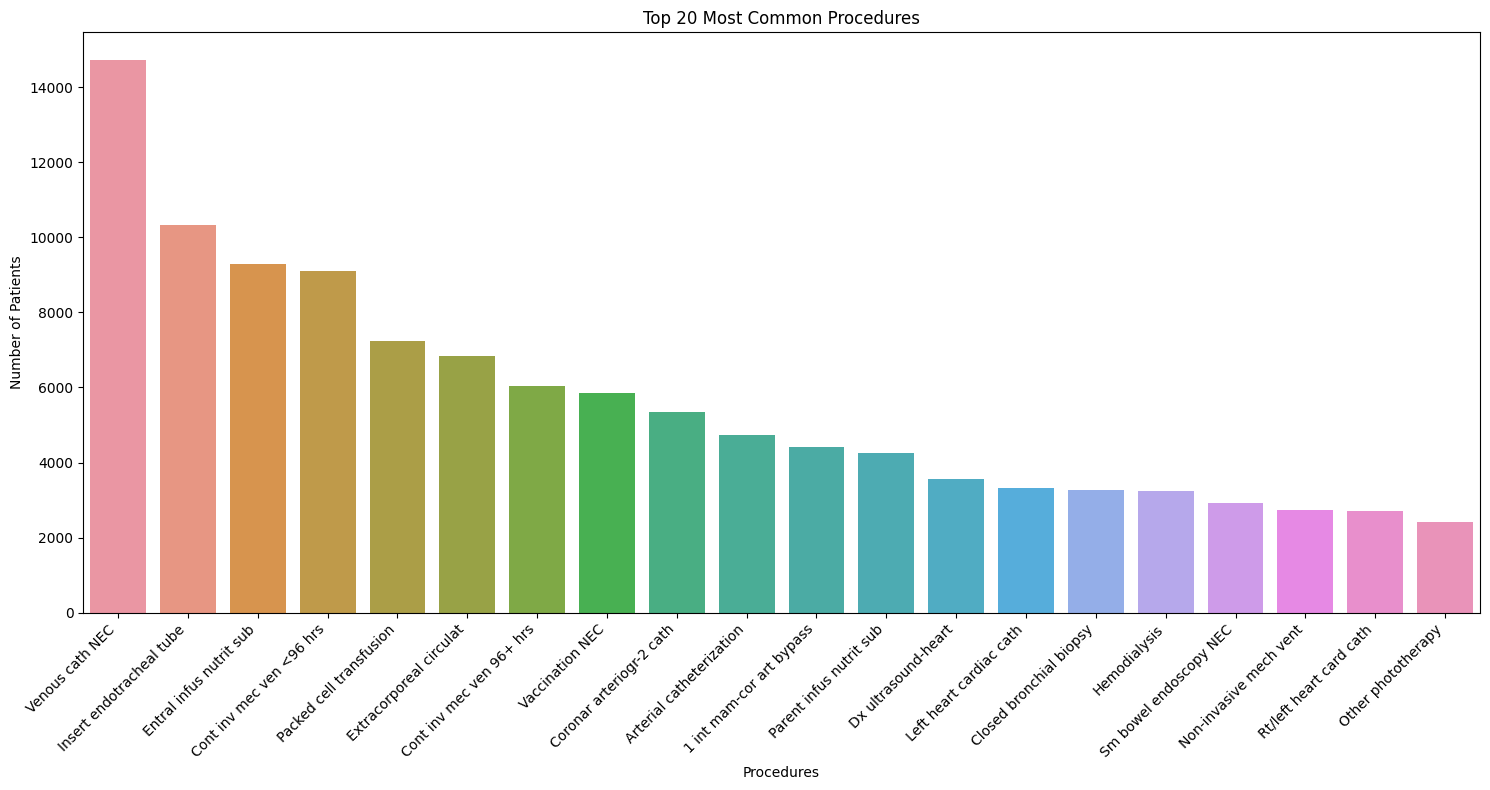

In [ ]:
# Count the occurrences of each icd
procedure_counts = procedure_merged['SHORT_TITLE'].value_counts()

# Take the top 20 most common icd
top_precedure = procedure_counts.head(20)

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(x=top_precedure.index, y=top_precedure.values)
plt.title('Top 20 Most Common Procedures')
plt.xlabel('Procedures')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')  # Rotate the procedures names for better readability
plt.tight_layout()
plt.show()

In [ ]:
# Filter for HADM_ID 150871
procedures150871 = procedure_merged[procedure_merged['HADM_ID'] == 150871][['ICD9_CODE', 'SHORT_TITLE']]

# Display the filtered data
print(procedures150871)

       ICD9_CODE               SHORT_TITLE
232505      8856  Coronar arteriogr-2 cath
240086      3523  Opn/oth rep mtrl vlv-tis
240087      3733  Exc/dest hrt lesion open
240088      3961   Extracorporeal circulat
240089      3727           Cardiac mapping
240090      3736    Exc,destrct,exclus LAA
240091      3893           Venous cath NEC
240092      8872       Dx ultrasound-heart
240093      3893           Venous cath NEC
240094      3722   Left heart cardiac cath


This shows one admission can also have multiple procedures

### 7. PROCEDUREEVENTS_MV.csv

In [ ]:
#procedureevents_mv

### 8. D_LABITEMS.csv

In [ ]:
#d_labitems

### 9. LABEVENTS.csv

In [ ]:
#labevents

### lab_merged
Merge lab items with lab events

In [ ]:
# Merge lab_event with lab_item using a left merge
lab_merged = pd.merge(labevents, d_labitems, on='ITEMID', how='left')
lab_merged

,ROW_ID_x,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,ROW_ID_y,LABEL,FLUID,CATEGORY,LOINC_CODE
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN,21,pH,Blood,Blood Gas,11558-4
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN,1,SPECIMEN TYPE,BLOOD,BLOOD GAS,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN,3,Base Excess,Blood,Blood Gas,11555-0
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN,5,Calculated Total CO2,Blood,Blood Gas,34728-6
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal,9,Free Calcium,Blood,Blood Gas,1994-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27854050,27428435,96443,103219.0,50882,2109-12-30 01:40:00,26,26.00,mEq/L,NaN,83,Bicarbonate,Blood,Chemistry,1963-8
27854051,27428436,96443,103219.0,50885,2109-12-30 01:40:00,2.1,2.10,mg/dL,abnormal,86,"Bilirubin, Total",Blood,Chemistry,1975-2
27854052,27428437,96443,103219.0,50902,2109-12-30 01:40:00,97,97.00,mEq/L,NaN,103,Chloride,Blood,Chemistry,2075-0
27854053,27428438,96443,103219.0,50911,2109-12-30 01:40:00,2,2.00,ng/mL,NaN,112,"Creatine Kinase, MB Isoenzyme",Blood,Chemistry,6773-6


In [ ]:
duplicated_count = lab_merged.duplicated().sum()
print(f"Number of duplicated rows: {duplicated_count}")

Number of duplicated rows: 0


Show lab category

In [ ]:
# Get the counts for each unique value in CATEGORY
category_counts = lab_merged['CATEGORY'].value_counts()

print(category_counts)

Hematology    11872248
Chemistry     10971567
Blood Gas      4593241
BLOOD GAS       404785
CHEMISTRY        12201
HEMATOLOGY          13
Name: CATEGORY, dtype: int64


There are mainly 3 categories here. **Hematology, Chemistry and Blood Gas** are repeated in uppercase letter.

A blood gas test, often referred to as an arterial blood gas (ABG) test, is a procedure that measures the amounts of oxygen and carbon dioxide in the blood, as well as the balance of acid and base (pH level). It provides information about how well the lungs are able to move oxygen into the blood and remove carbon dioxide from the blood.

In [ ]:
# Filter the DataFrame for rows where CATEGORY is 'Blood Gas'
bloodgas_df = lab_merged[lab_merged['CATEGORY'].str.lower() == 'blood gas']

# Get unique values in the 'LABEL' column
bloodgas_labels = bloodgas_df['LABEL'].unique()
print(bloodgas_labels)

['pH' 'SPECIMEN TYPE' 'Base Excess' 'Calculated Total CO2' 'Free Calcium'
 'Intubated' 'Lactate' 'pCO2' 'pO2' 'Temperature' 'Oxygen'
 'Oxygen Saturation' 'PEEP' 'Tidal Volume' 'Ventilation Rate' 'Ventilator'
 'Hematocrit, Calculated' 'Hemoglobin' 'Glucose' 'Potassium, Whole Blood'
 'Alveolar-arterial Gradient' 'Required O2' 'Sodium, Whole Blood'
 'Calculated Bicarbonate, Whole Blood' 'Chloride, Whole Blood' 'O2 Flow'
 'Methemoglobin' 'Carboxyhemoglobin' 'Fluid Type' 'pO2, Body Fluid'
 'pCO2, Body Fluid' 'Potassium' 'Sodium, Body Fluid']


In [ ]:
# Filter the DataFrame for rows where CATEGORY is 'Hematology'
hematology_df = lab_merged[lab_merged['CATEGORY'].str.lower() == 'hematology']

# Get unique values in the 'LABEL' column
hematology_labels = hematology_df['LABEL'].unique()
print(hematology_labels)

['Hematocrit' 'Anisocytosis' 'Basophils' 'Eosinophils' 'Hemoglobin'
 'Hypochromia' 'Lymphocytes' 'Macrocytes' 'MCH' 'MCHC' 'MCV' 'Microcytes'
 'Monocytes' 'Neutrophils' 'Platelet Count' 'Poikilocytosis' 'RDW'
 'Red Blood Cell Fragments' 'Red Blood Cells' 'White Blood Cells'
 'Bilirubin' 'Blood' 'Glucose' 'Ketone' 'Leukocytes' 'Nitrite' 'pH'
 'Protein' 'Specific Gravity' 'Urine Appearance' 'Urine Color'
 'Urobilinogen' 'Bacteria' 'Epithelial Cells' 'Hyaline Casts' 'RBC'
 'Urine Mucous' 'WBC' 'Yeast' 'PTT' 'INR(PT)' 'PT'
 'Fibrinogen, Functional' 'Atypical Lymphocytes' 'Bands' 'Metamyelocytes'
 'Myelocytes' 'Polychromasia' 'Nucleated Red Cells' 'Platelet Smear'
 'Absolute CD3 Count' 'Absolute CD4 Count' 'Absolute CD8 Count'
 'Absolute Lymphocyte Count' 'CD3 Cells, Percent' 'CD4 Cells, Percent'
 'CD4/CD8 Ratio' 'CD8 Cells, Percent' 'Lymphocytes, Percent' 'WBC Count'
 'Transitional Epithelial Cells' 'D-Dimer' 'Fibrin Degradation Products'
 'Reticulocyte Count, Automated' 'Burr Cells' 'WBC 

In [ ]:
# Filter the DataFrame for rows where CATEGORY is 'Chemistry'
chemistry_df = lab_merged[lab_merged['CATEGORY'].str.lower() == 'chemistry']

# Get unique values in the 'LABEL' column
chemistry_labels = chemistry_df['LABEL'].unique()
print(chemistry_labels)

['Anion Gap' 'Bicarbonate' 'Calcium, Total' 'Chloride' 'Creatinine'
 'Glucose' 'Magnesium' 'Phosphate' 'Potassium' 'Sodium' 'Urea Nitrogen'
 'Vancomycin' 'Alanine Aminotransferase (ALT)'
 'Asparate Aminotransferase (AST)' 'Creatine Kinase (CK)'
 'Creatine Kinase, MB Isoenzyme' 'Troponin I' 'Alkaline Phosphatase'
 'Bilirubin, Total' 'Albumin' 'Amylase' 'Lipase' 'Uric Acid'
 'Bilirubin, Direct' 'Bilirubin, Indirect' 'Cholesterol Ratio (Total/HDL)'
 'Cholesterol, HDL' 'Cholesterol, LDL, Measured' 'Cholesterol, Total'
 'Triglycerides' 'Blue Top Hold' 'Gamma Glutamyltransferase'
 'Lactate Dehydrogenase (LD)' 'Chloride, Urine' 'Creatinine, Urine'
 'Length of Urine Collection' 'Osmolality, Urine' 'Sodium, Urine'
 'Urea Nitrogen, Urine' 'Ferritin' 'Iron' 'Iron Binding Capacity, Total'
 'Transferrin' 'CK-MB Index' 'Osmolality, Measured' 'Red Top Hold'
 'Thyroid Stimulating Hormone' 'Thyroxine (T4)' 'Green Top Hold (plasma)'
 'Cholesterol, LDL, Calculated' 'GR HOLD' '% Hemoglobin A1c' 'EDTA Hold

In [ ]:
# Get the counts for each unique value in CATEGORY
fluid_counts = lab_merged['FLUID'].value_counts()

print(fluid_counts)

Blood                        25341470
Urine                         1964068
BLOOD                          405141
Cerebrospinal Fluid (CSF)       35917
Ascites                         31224
Pleural                         28393
Other Body Fluid                24667
URINE                           11850
Bone Marrow                      5368
Joint Fluid                      5319
Stool                             630
OTHER BODY FLUID                    6
JOINT FLUID                         2
Name: FLUID, dtype: int64


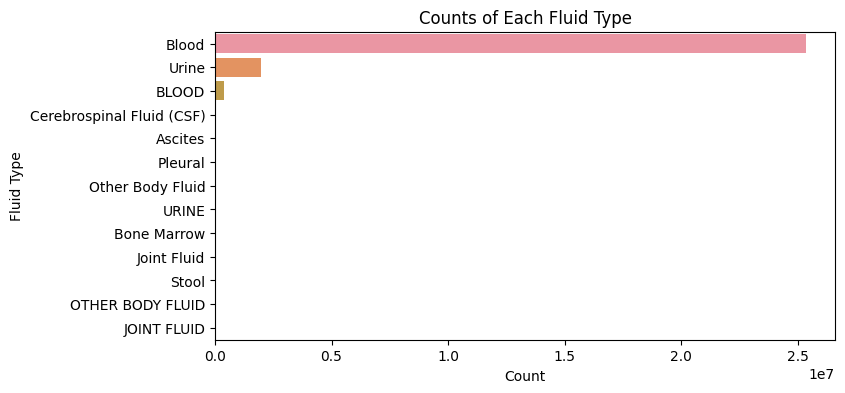

In [ ]:
# Plot fluid counts
plt.figure(figsize=(8, 4))
sns.barplot(y=fluid_counts.index, x=fluid_counts.values)

plt.title('Counts of Each Fluid Type')
plt.xlabel('Count')
plt.ylabel('Fluid Type')
plt.show()

The most common fluid type for lab test is blood.

### 10. MICROBIOLOGYEVENTS.csv

- CHARTDATE: The date the event occurred.
- CHARTTIME: The date and time the event occurred (if available).
- SPEC_ITEMID: Item ID for the specimen type.
- ORG_ITEMID: Item ID for the organism.
- ISOLATE_NUM: Number of organisms isolated from the same sample.
- AB_ITEMID: Item ID for the antibiotic.
- DILUTION_TEXT: Text description of the antibiotic dilution.
- DILUTION_COMPARISON: Comparison used for the antibiotic dilution.
- DILUTION_VALUE: Value of the antibiotic dilution.
- INTERPRETATION: Interpretation of the antibiotic dilution.

In [ ]:
microbiologyevents

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,SPEC_ITEMID,SPEC_TYPE_DESC,ORG_ITEMID,ORG_NAME,ISOLATE_NUM,AB_ITEMID,AB_NAME,DILUTION_TEXT,DILUTION_COMPARISON,DILUTION_VALUE,INTERPRETATION
0,744,96,170324,2156-04-13 00:00:00,2156-04-13 14:18:00,70021.0,BRONCHOALVEOLAR LAVAGE,80026.0,PSEUDOMONAS AERUGINOSA,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,745,96,170324,2156-04-20 00:00:00,2156-04-20 13:10:00,70062.0,SPUTUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,746,96,170324,2156-04-20 00:00:00,2156-04-20 16:00:00,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,747,96,170324,2156-04-20 00:00:00,NaN,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,748,96,170324,2156-04-20 00:00:00,NaN,70079.0,URINE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631721,630931,99783,126090,2125-11-05 00:00:00,2125-11-05 13:15:00,70076.0,TISSUE,80066.0,ASPERGILLUS FUMIGATUS,2.0,NaN,NaN,NaN,NaN,NaN,NaN
631722,630932,99783,126090,2125-11-06 00:00:00,2125-11-06 10:24:00,70076.0,TISSUE,80066.0,ASPERGILLUS FUMIGATUS,1.0,NaN,NaN,NaN,NaN,NaN,NaN
631723,630933,99783,126090,2125-11-06 00:00:00,2125-11-06 10:24:00,70076.0,TISSUE,80066.0,ASPERGILLUS FUMIGATUS,2.0,NaN,NaN,NaN,NaN,NaN,NaN
631724,630934,99783,126090,2125-11-07 00:00:00,2125-11-07 12:40:00,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
microbiologyevents['ORG_NAME'].nunique()

362

There are 362 unique microorganisms in this dataset. Let's check what's the top 20 most common microorganisms.

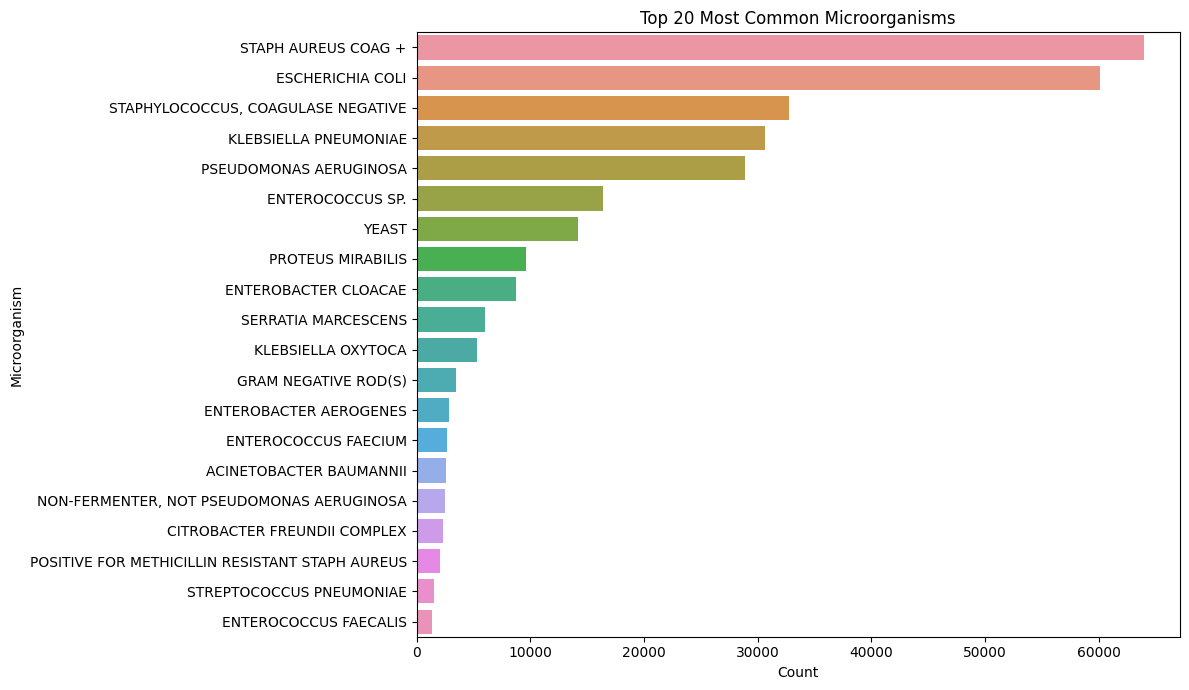

In [ ]:
# Get the top 20 most common microorganisms
top_microorganisms = microbiologyevents['ORG_NAME'].value_counts().head(20)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(y=top_microorganisms.index, x=top_microorganisms.values)
plt.title('Top 20 Most Common Microorganisms')
plt.xlabel('Count')
plt.ylabel('Microorganism')
plt.tight_layout()
plt.show()

The chart above shows the most common microorganisms are Staphylococcus aureus and Escherichia coli.

A network graph where microorganisms and antibiotics are nodes, and edges represent associations (i.e., which antibiotic is tested against which organism).

In [ ]:
#!pip install networkx

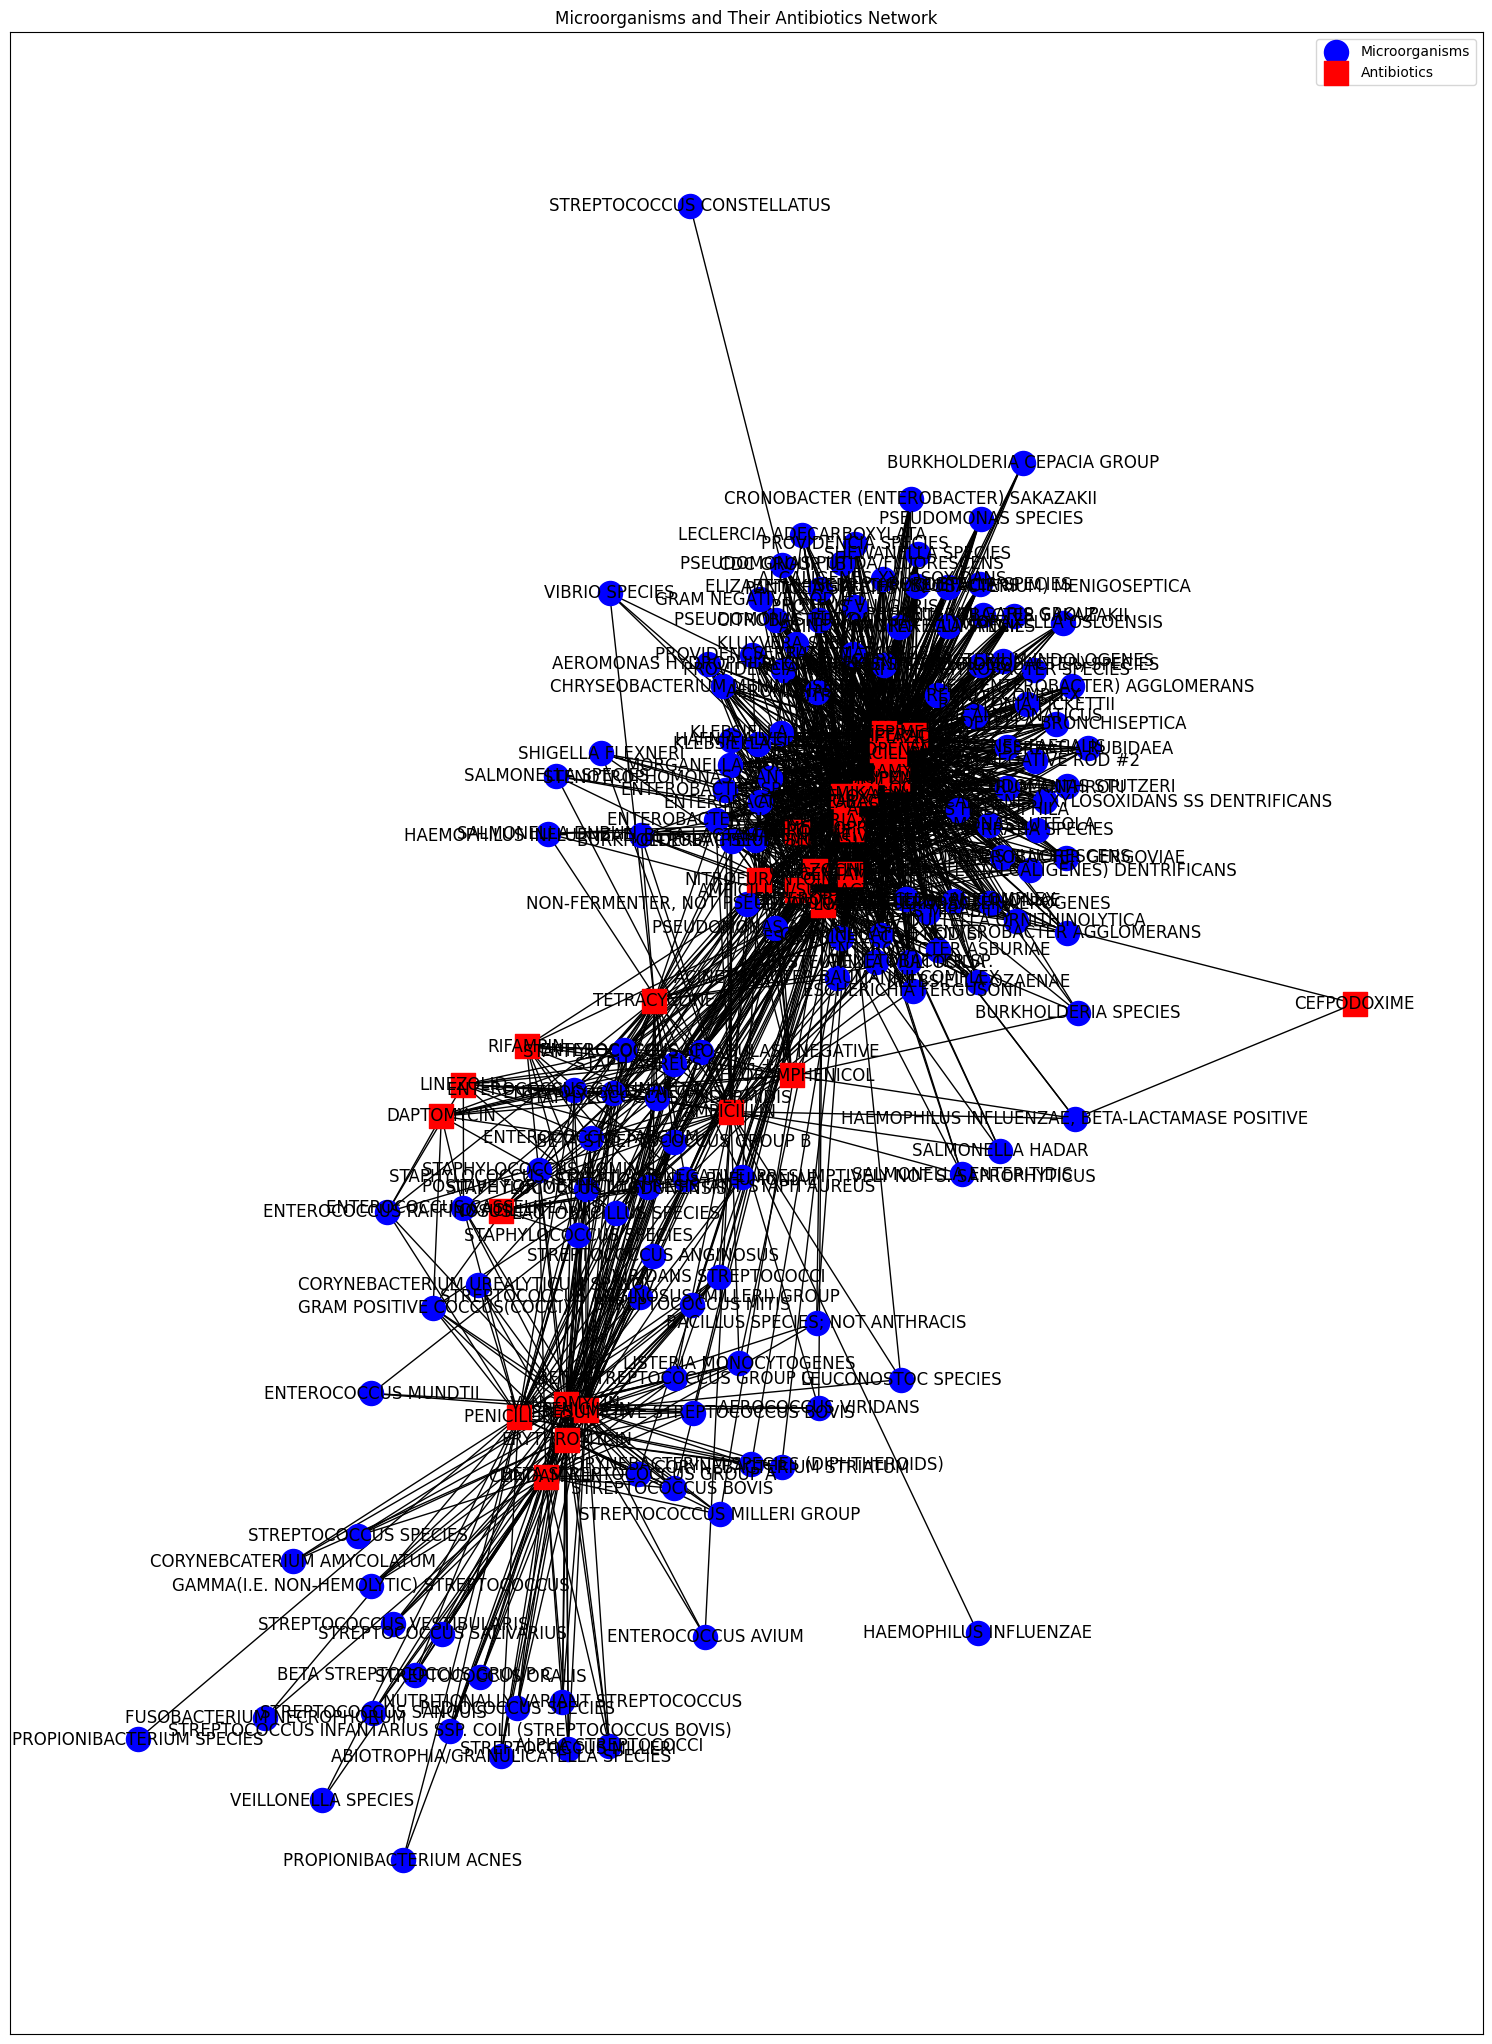

In [ ]:
# Create a new graph
G = nx.Graph()

# Add nodes for each microorganism and antibiotic
for org, ab in microbiologyevents[['ORG_NAME', 'AB_NAME']].dropna().values:
    G.add_node(org, type='organism')
    G.add_node(ab, type='antibiotic')
    G.add_edge(org, ab)

# Draw the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(19, 26))

# Draw organisms
org_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'organism']
nx.draw_networkx_nodes(G, pos, nodelist=org_nodes, node_color='blue', label='Microorganisms')

# Draw antibiotics
ab_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'antibiotic']
nx.draw_networkx_nodes(G, pos, nodelist=ab_nodes, node_color='red', label='Antibiotics', node_shape='s')

# Draw edges
nx.draw_networkx_edges(G, pos)

# Draw labels
nx.draw_networkx_labels(G, pos)

plt.title('Microorganisms and Their Antibiotics Network')
plt.legend()
plt.show()

### 11. ICUSTAYS.csv

In [ ]:
#icustays

### 12. NOTEEVENTS.csv

care givers (CGID)

In [ ]:
#noteevents

### Other tables

In [ ]:
#d_items

In [ ]:
#callout

In [ ]:
#caregivers

In [ ]:
#cptevents

In [ ]:
#d_cpt

In [ ]:
#datetimeevents

In [ ]:
#drgcodes

In [ ]:
#inputevents_cv

In [ ]:
#inputevents_mv

In [ ]:
#outputevents

In [ ]:
#prescriptions

In [ ]:
#services

In [ ]:
#transfers